# MODELISATION

In [ ]:
import pickle
import os
import sys
import time

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models.doc2vec import Doc2Vec
from gensim.models import KeyedVectors

import paths

In [ ]:
# Read the features datasets
X_train = pd.read_csv(paths.TRAIN_FEATS_PATH)
train_target = pd.read_csv(paths.TRAIN_TARGET_PATH, header=None).to_numpy().ravel()

X_test = pd.read_csv(paths.TEST_FEATS_PATH)
test_target = pd.read_csv(paths.TEST_TARGET_PATH, header=None).to_numpy().ravel()

X_challenge = pd.read_csv(paths.CHALLENGE_FEATS_PATH)

In [ ]:
# Read the Doc2vec model
doc2vec_model = Doc2Vec.load(paths.DOC2VEC_PATH)

# Read nodes embeddings
node2vec_train = KeyedVectors.load_word2vec_format(paths.NODE2VEC_TRAIN_PATH)
node2vec_test = KeyedVectors.load_word2vec_format(paths.NODE2VEC_TEST_PATH)
node2vec_full_graph = KeyedVectors.load_word2vec_format(paths.NODE2VEC_FULL_GRAPH_PATH)

## 5. Model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score, log_loss, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

In [ ]:
train_pairs = X_train[['node_1', 'node_2']].copy()
test_pairs = X_test[['node_1', 'node_2']].copy()
challenge_pairs = X_challenge[['node_1', 'node_2']].copy()

In [ ]:
X_train.drop(columns=['node_1', 'node_2', 'sum_degree', 'diff_pagerank'], inplace=True)
X_test.drop(columns=['node_1', 'node_2', 'sum_degree', 'diff_pagerank'], inplace=True)
X_challenge.drop(columns=['node_1', 'node_2', 'sum_degree', 'diff_pagerank'], inplace=True)

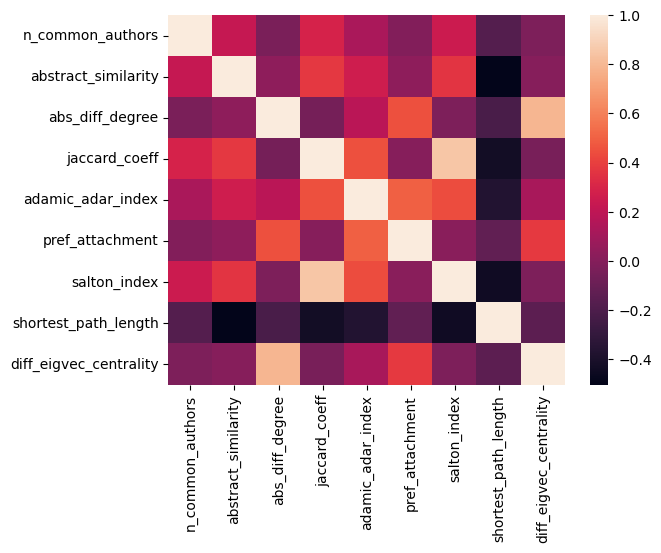

In [ ]:
sns.heatmap(X_train.corr())
plt.show()

## 4. Add Link embeddings

Since we have the node/paper embeddings, we have to compute a link embedding because our datasets contain link (pairs of nodes). We define the following operators to do so

In [ ]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0

### Link topological embeddings

In [ ]:
def get_node_embedding(node, node_vectors):
    """
    Get the embedding of a node from node2vec model.
    """
    return node_vectors[str(node)]


def link_graph_embedding(link_examples, node_vectors, binary_operator):
    return [
        binary_operator(
            get_node_embedding(node_1, node_vectors),
            get_node_embedding(node_2, node_vectors)
        )
        for node_1, node_2 in link_examples
    ]


### Link semantic embeddings

In [ ]:
def get_semantic_embedding(node, model):
    """
    Get the embedding of a node from node2vec model.
    """
    return model.docvecs[node]


def link_semantic_embedding(link_examples, binary_operator, model=doc2vec_model):
    return [
        binary_operator(
            get_semantic_embedding(paper_1, model),
            get_semantic_embedding(paper_2, model)
        )
        for paper_1, paper_2 in link_examples
    ]


In [ ]:
X_train_graph_emb = link_graph_embedding(
    train_pairs.to_numpy(),
    node2vec_train,
    binary_operator=operator_l1
)
X_train_sem_emb = link_semantic_embedding(
    train_pairs.to_numpy(),
    binary_operator=operator_l1
)

X_train_c = np.concatenate(
    (X_train.to_numpy(), np.array(X_train_graph_emb), np.array(X_train_sem_emb)),
    axis=1
)
print("Shape of X_train:", X_train_c.shape)

Shape of X_train: (349424, 201)


In [ ]:
X_test_graph_emb = link_graph_embedding(
    test_pairs.to_numpy(),
    node2vec_test,
    binary_operator=operator_l1
)
X_test_sem_emb = link_semantic_embedding(
    test_pairs.to_numpy(),
    binary_operator=operator_l1
)

X_test_c = np.concatenate(
    (X_test.to_numpy(), np.array(X_test_graph_emb), np.array(X_test_sem_emb)),
    axis=1
)
print("Shape of X_test:", X_test_c.shape)

Shape of X_test: (436782, 201)


In [ ]:
X_challenge_graph_emb = link_graph_embedding(
    challenge_pairs.to_numpy(),
    node2vec_full_graph,
    binary_operator=operator_l1
)
X_challenge_sem_emb = link_semantic_embedding(
    challenge_pairs.to_numpy(),
    binary_operator=operator_l1
)

X_challenge_c = np.concatenate(
    (X_challenge.to_numpy(), np.array(X_challenge_graph_emb), np.array(X_challenge_sem_emb)),
    axis=1
)
print("Shape of X_challenge:", X_challenge_c.shape)

Shape of X_challenge: (106692, 201)


In [ ]:
X_new_c = np.concatenate((X_train_c, X_test_c))
y_new = np.concatenate((train_target, test_target))

In [ ]:
scaler = StandardScaler()
X_new_sc = scaler.fit_transform(X_new_c)
X_challenge_sc = scaler.transform(X_challenge_c)

lr_clf = XGBClassifier(
    sub_sample=0.8,learning_rate = 0.2,colsample_bytree=0.6,max_depth=5,
    n_estimators=100,min_child_weight=5,gamma=5
)
lr_clf.fit(X_new_sc, y_new)

/Users/kevinab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:46:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:46:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_c)
X_test_sc = scaler.transform(X_test_c)
X_challenge_sc = scaler.transform(X_challenge_c)

lr_clf = LogisticRegression()
lr_clf.fit(X_train_sc, train_target)

LogisticRegression()

In [ ]:
log_loss(y_new, lr_clf.predict_proba(X_new_sc)[:,1])

0.10884700054453772

In [ ]:
import csv
y_pred = lr_clf.predict_proba(X_challenge_sc)
y_pred = y_pred[:,1]

# Write predictions to a file
predictions = zip(range(len(y_pred)), y_pred)
with open("submission.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for row in predictions:
        csv_out.writerow(row) 